## Purpose of script

**Input data:**
- The Full TCGA data set, with missing data and additional features, created in the R scrpt 'Full TCGA data'.

**Output data:**
- A full TCGA data set without missing data and without the additional features. 

# Data imuputation

To test which data imputation method will be best for this data set I will test two methods provided by sklearn: `KNNImputer`, `IterativeImputer`. For evaluation of these methods I will run the data through Random Forest and XGBoost for predicting cancer type, observing if there is a difference in the prediction accuracy.

Only the protein columns will have data imputation run on it as the additional patient information is difficult to predict, particularly as I have removed most other patient information that was collected to create the `Full_TCGA_data_missing_values.csv` file.

## Importing data

In [1]:
# Importing necessary packages
import pandas as pd 
import numpy as np

In [2]:
# Reading in the Full TCGA data set produced in R studio using the `FULL_TCGA_data.Rmd` R script.
# This data set contains all of the TCGA cancer studies that will be used in the current study.
# This data set contains all proteins which have less than 50% of patients without data.

Full_TCGA_data_not_fill = pd.read_csv("../R/Data/Processed_Data/Full_TCGA_data_missing_values.csv")
Full_TCGA_data_not_fill.head()


,Unnamed: 0,case.submitter.id,project_id,age,primary_diagnosis,stage,site_of_biopsy,cigarettes_per_day,years_smoked,days_to_death,...,XPF,XRCC1,YAP,YAP_pS127,YB1,YB1_pS102,YTHDF2,YTHDF3,ZAP.70,ZEB1
0,TCGA-DM-A28A-01A-11-A17M-20_RPPA_data.tsv,TCGA-DM-A28A,TCGA-COAD,78.0,"Adenocarcinoma, NOS",Stage IIIC,Cecum,NaN,NaN,805.0,...,-0.253891,-0.05595,-0.12032,0.042403,0.15596,-0.44727,0.184465,0.099395,-1.142633,0.050361
1,TCGA-3R-A8YX-01A-21-A456-20_RPPA_data.tsv,TCGA-3R-A8YX,TCGA-SARC,66.0,Dedifferentiated liposarcoma,'--,Retroperitoneum,NaN,NaN,17.0,...,-0.268165,-0.28342,-0.12573,0.302280,-0.43544,0.73363,0.220226,0.265941,-1.685293,0.529938
2,TCGA-IQ-A61L-01A-21-A45L-20_RPPA_data.tsv,TCGA-IQ-A61L,TCGA-HNSC,72.0,"Squamous cell carcinoma, keratinizing, NOS",Stage II,"Tongue, NOS",NaN,NaN,NaN,...,0.059710,-0.61597,0.41376,0.316490,0.18067,0.43394,-0.446973,0.302260,-0.240030,0.236229
3,TCGA-08-0357-01A-21-1898-20_RPPA_data.tsv,TCGA-08-0357,TCGA-GBM,49.0,Glioblastoma,'--,"Brain, NOS",NaN,NaN,1143.0,...,0.172386,-0.26990,-0.03664,-0.202700,-0.40270,0.63614,-0.096602,0.015607,-0.435979,0.724035
4,TCGA-Z7-A8R5-01A-51-A43F-20_RPPA_data.tsv,TCGA-Z7-A8R5,TCGA-BRCA,61.0,"Lobular carcinoma, NOS",Stage IIIA,"Breast, NOS",NaN,NaN,NaN,...,0.200433,0.14471,-0.26083,-0.369120,-0.37733,-0.13080,-0.510200,-0.669885,0.307318,0.398703


In [3]:
# Removing (but keeping a copy to added back in) the additional information columns other than the `project_id` which will be used for determining cancer type
Full_TCGA_other_features = pd.DataFrame(Full_TCGA_data_not_fill[[ 'Unnamed: 0', 'age', 'cigarettes_per_day', 'years_smoked', 'primary_diagnosis', 'days_to_death', 'case.submitter.id', 'site_of_biopsy', 'stage']])
Full_TCGA_data_not_fill = Full_TCGA_data_not_fill.drop(['Unnamed: 0', 'age', 'cigarettes_per_day', 'years_smoked', 'primary_diagnosis', 'days_to_death', 'case.submitter.id', 'site_of_biopsy', 'stage'], axis=1)

# Checking number of NA values in each column
Full_TCGA_data_not_fill.isna().sum()

project_id       0
1433BETA         0
1433EPSILON      0
1433ZETA         0
4EBP1            0
              ... 
YB1_pS102        0
YTHDF2         404
YTHDF3         404
ZAP.70         404
ZEB1           404
Length: 457, dtype: int64

In [9]:
# Converting cancer type into numerical values as KNNImputer requires a numerical input
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-GBM", value="0", inplace=True) # GBM (Glioblastoma multiforme)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-LGG", value="1", inplace=True) # LGG (Brain Lower Grade Glioma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-HNSC", value="2", inplace=True) # HNSC (Head and Neck squamous cell carcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-THCA", value="3", inplace=True) # THCA (Thyroid carcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-ESCA", value="4", inplace=True) # ESCA (Esophageal carcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-SARC", value="5", inplace=True) # SARC (Sarcoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-SKCM", value="6", inplace=True) # SKCM (Skin Cutaneous Melanoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-LUAD", value="7", inplace=True) # LUAD (Lung adenocarcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-LUSC", value="8", inplace=True) # LUSC (Lung squamous cell carcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-MESO", value="9", inplace=True) # MESO (Mesothelioma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-THYM", value="10", inplace=True) # THYM (Thymoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-BRCA", value="11", inplace=True) # BRCA (Breast invasive carcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-STAD", value="12", inplace=True) # STAD (Stomach adenocarcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-LIHC", value="13", inplace=True) # LIHC (Liver hepatocellular carcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-PAAD", value="14", inplace=True) # PAAD (Pancreatic adenocarcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-ACC", value="15", inplace=True) # ACC (Adrenocortical carcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-PCPG", value="16", inplace=True) # PCPG (Pheochromocytoma (adrenal) and Paraganglioma (nerves in neck and head))
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-KIRC", value="17", inplace=True) # KIRC (Kidney renal clear cell carcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-KICH", value="18", inplace=True) # KICH (Kidney Chromophobe)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-KIRP", value="19", inplace=True) # KIRP (Kidney renal papillary cell carcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-COAD", value="20", inplace=True) # COAD (Colon adenocarcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-READ", value="21", inplace=True) # READ (Rectum adenocarcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-OV", value="22", inplace=True) # OVCA(OV, Ovarian serous cystadenocarcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-UCEC", value="23", inplace=True) # UCEC (Uterine Corpus Endometrial Carcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-CESC", value="24", inplace=True) # CESC (Cervical squamous cell carcinoma and endocervical adenocarcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-PRAD", value="25", inplace=True) # PRAD (Prostate adenocarcinoma)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-TGCT", value="26", inplace=True) # TGCT (Testicular Germ Cell Tumors)
Full_TCGA_data_not_fill['project_id'].replace(to_replace="TCGA-BLCA", value="27", inplace=True) # BLCA (Bladder Urothelial Carcinoma)


# Checking it was done correctly
Full_TCGA_data_not_fill.project_id.unique()

array(['20', '5', '2', '0', '11', '17', '3', '19', '25', '12', '10', '26',
       '9', '14', '4', '22', '27', '1', '21', '7', '6', '24', '23', '8',
       '16', '13', '15', '18'], dtype=object)

## Data Imputation - KNN Imputer

In [10]:
# Using the KNNImputer function to fill in missing values in data set
from sklearn.impute import KNNImputer
impute_knn = KNNImputer(n_neighbors=5)

filled = impute_knn.fit_transform(Full_TCGA_data_not_fill)
filled

array([[ 2.00000000e+01, -1.92760000e-01, -1.47480000e-01, ...,
         9.93948000e-02, -1.14263300e+00,  5.03609400e-02],
       [ 5.00000000e+00,  6.60820000e-02,  1.10780000e-03, ...,
         2.65941344e-01, -1.68529292e+00,  5.29938334e-01],
       [ 2.00000000e+00,  2.76100000e-02,  9.84790000e-02, ...,
         3.02259500e-01, -2.40030300e-01,  2.36229000e-01],
       ...,
       [ 1.70000000e+01,  7.23450000e-02, -2.18490000e-04, ...,
        -3.97039700e-01, -1.62978600e-01, -1.62374200e-01],
       [ 2.00000000e+00, -4.67160000e-02,  2.23010000e-01, ...,
         1.21470300e-01, -6.85214900e-01,  1.00348100e-01],
       [ 2.00000000e+00, -6.05510000e-02,  3.56830000e-02, ...,
         2.71825400e-01,  5.19005600e-01, -8.26369100e-02]])

In [11]:
# Converting the filled in dataset from array back to dataframe
KNN_filled = pd.DataFrame(filled, columns=Full_TCGA_data_not_fill.columns)
KNN_filled.to_csv("../R/Data/Processed_Data/KNN_filled_data.csv")
KNN_filled.head()


,project_id,1433BETA,1433EPSILON,1433ZETA,4EBP1,4EBP1_pS65,4EBP1_pT37T46,4EBP1_pT70,53BP1,ACC_pS79,...,XPF,XRCC1,YAP,YAP_pS127,YB1,YB1_pS102,YTHDF2,YTHDF3,ZAP.70,ZEB1
0,20.0,-0.192760,-0.147480,0.274320,-0.166640,0.131930,-0.40350,-0.06129,-0.157290,-0.132990,...,-0.253891,-0.05595,-0.12032,0.042403,0.15596,-0.44727,0.184465,0.099395,-1.142633,0.050361
1,5.0,0.066082,0.001108,-0.339410,1.317600,0.739550,1.85960,0.59793,-0.313170,0.358690,...,-0.268165,-0.28342,-0.12573,0.302280,-0.43544,0.73363,0.220226,0.265941,-1.685293,0.529938
2,2.0,0.027610,0.098479,0.795980,0.715850,0.055499,-0.25660,0.19369,-0.746940,0.100000,...,0.059710,-0.61597,0.41376,0.316490,0.18067,0.43394,-0.446973,0.302260,-0.240030,0.236229
3,0.0,-0.035859,0.595400,-0.469200,-0.417240,0.353760,2.21680,-0.20124,0.319750,-0.271450,...,0.172386,-0.26990,-0.03664,-0.202700,-0.40270,0.63614,-0.096602,0.015607,-0.435979,0.724035
4,11.0,0.062445,-0.024017,0.064135,0.082556,-0.477660,-0.33589,-0.33266,-0.085562,-0.048454,...,0.200433,0.14471,-0.26083,-0.369120,-0.37733,-0.13080,-0.510200,-0.669885,0.307318,0.398703


## Data Imputation - IterativeImputer

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Setting the random_state argument for reproducibility
imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(Full_TCGA_data_not_fill)
df_imputed = pd.DataFrame(imputed, columns=Full_TCGA_data_not_fill.columns)


c:\Users\Eloisa\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [13]:
df_imputed.to_csv("../R/Data/Processed_Data/Itera_filled_data.csv")
df_imputed 


,project_id,1433BETA,1433EPSILON,1433ZETA,4EBP1,4EBP1_pS65,4EBP1_pT37T46,4EBP1_pT70,53BP1,ACC_pS79,...,XPF,XRCC1,YAP,YAP_pS127,YB1,YB1_pS102,YTHDF2,YTHDF3,ZAP.70,ZEB1
0,20.0,-0.192760,-0.147480,0.274320,-0.166640,0.131930,-0.40350,-0.061290,-0.157290,-0.132990,...,-0.253891,-0.05595,-0.120320,0.042403,0.155960,-0.447270,0.184465,0.099395,-1.142633,0.050361
1,5.0,0.066082,0.001108,-0.339410,1.317600,0.739550,1.85960,0.597930,-0.313170,0.358690,...,-0.268165,-0.28342,-0.125730,0.302280,-0.435440,0.733630,0.220226,0.265941,-1.685293,0.529938
2,2.0,0.027610,0.098479,0.795980,0.715850,0.055499,-0.25660,0.193690,-0.746940,0.100000,...,0.059710,-0.61597,0.413760,0.316490,0.180670,0.433940,-0.446973,0.302260,-0.240030,0.236229
3,0.0,-0.035859,0.595400,-0.469200,-0.417240,0.353760,2.21680,-0.201240,0.319750,-0.271450,...,0.172386,-0.26990,-0.036640,-0.202700,-0.402700,0.636140,-0.096602,0.015607,-0.435979,0.724035
4,11.0,0.062445,-0.024017,0.064135,0.082556,-0.477660,-0.33589,-0.332660,-0.085562,-0.048454,...,0.200433,0.14471,-0.260830,-0.369120,-0.377330,-0.130800,-0.510200,-0.669885,0.307318,0.398703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778,1.0,0.242760,0.261030,-0.171030,-0.583020,0.004396,0.73020,0.020634,-0.252620,0.351020,...,-0.112992,-0.22526,-0.381890,-1.111800,-0.491300,0.147710,-0.088106,-0.506119,-1.627865,0.526855
7779,12.0,0.016898,0.218300,-0.239770,-0.625310,-0.296810,0.26496,-0.241040,-1.015000,-0.417640,...,-0.109703,-0.29444,-0.221170,-0.293090,3.230600,-0.035081,-0.992544,-0.215902,-0.191537,-0.117434
7780,17.0,0.072345,-0.000218,-0.308310,-0.376480,-0.352760,0.16194,-0.027246,-0.420020,-0.320410,...,-0.027934,-0.28393,-0.029973,1.048800,-0.143350,0.853060,-0.379810,-0.397040,-0.162979,-0.162374
7781,2.0,-0.046716,0.223010,0.497580,0.783810,0.364310,0.67137,0.187630,-0.839780,0.259350,...,0.165847,-0.48652,2.100800,2.752900,0.146780,0.361030,0.763812,0.121470,-0.685215,0.100348


## KNN Imputer - testing imputation by running through XGBoost

In [2]:
# XGBoost
import xgboost as xgb # XGBoost stuff
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during ...
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # draws a confusion matrix

In [4]:
X = KNN_filled.drop('project_id', axis=1).copy()
X.head()

,1433BETA,1433EPSILON,1433ZETA,4EBP1,4EBP1_pS65,4EBP1_pT37T46,4EBP1_pT70,53BP1,ACC_pS79,ACC1,...,XPF,XRCC1,YAP,YAP_pS127,YB1,YB1_pS102,YTHDF2,YTHDF3,ZAP.70,ZEB1
0,-0.192760,-0.147480,0.274320,-0.166640,0.131930,-0.40350,-0.06129,-0.157290,-0.132990,0.210540,...,-0.253891,-0.05595,-0.12032,0.042403,0.15596,-0.44727,0.184465,0.099395,-1.142633,0.050361
1,0.066082,0.001108,-0.339410,1.317600,0.739550,1.85960,0.59793,-0.313170,0.358690,0.378850,...,-0.268165,-0.28342,-0.12573,0.302280,-0.43544,0.73363,0.220226,0.265941,-1.685293,0.529938
2,0.027610,0.098479,0.795980,0.715850,0.055499,-0.25660,0.19369,-0.746940,0.100000,-0.289240,...,0.059710,-0.61597,0.41376,0.316490,0.18067,0.43394,-0.446973,0.302260,-0.240030,0.236229
3,-0.035859,0.595400,-0.469200,-0.417240,0.353760,2.21680,-0.20124,0.319750,-0.271450,0.103820,...,0.172386,-0.26990,-0.03664,-0.202700,-0.40270,0.63614,-0.096602,0.015607,-0.435979,0.724035
4,0.062445,-0.024017,0.064135,0.082556,-0.477660,-0.33589,-0.33266,-0.085562,-0.048454,-0.033844,...,0.200433,0.14471,-0.26083,-0.369120,-0.37733,-0.13080,-0.510200,-0.669885,0.307318,0.398703


In [5]:
y = KNN_filled['project_id'].copy()
y = y.astype(int)
y.head()

0    20
1     5
2     2
3     0
4    11
Name: project_id, dtype: int32

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=180)

In [7]:
clf_xgb = xgb.XGBClassifier(objective='multi:softmax', seed=42, early_stopping_rounds = 10, eta=0.1, eval_metric = 'merror', n_estimators=50, max_depth=6).fit(X_train,
            y_train,
            verbose=True,
            eval_set=[(X_test, y_test)])

[0]	validation_0-merror:0.16763
[1]	validation_0-merror:0.12203
[2]	validation_0-merror:0.10983
[3]	validation_0-merror:0.10083
[4]	validation_0-merror:0.08735
[5]	validation_0-merror:0.08414
[6]	validation_0-merror:0.07900
[7]	validation_0-merror:0.08028
[8]	validation_0-merror:0.07579
[9]	validation_0-merror:0.07514
[10]	validation_0-merror:0.07386
[11]	validation_0-merror:0.07129
[12]	validation_0-merror:0.07001
[13]	validation_0-merror:0.07001
[14]	validation_0-merror:0.06680
[15]	validation_0-merror:0.06487
[16]	validation_0-merror:0.06551
[17]	validation_0-merror:0.06294
[18]	validation_0-merror:0.06358
[19]	validation_0-merror:0.06358
[20]	validation_0-merror:0.06423
[21]	validation_0-merror:0.06358
[22]	validation_0-merror:0.06294
[23]	validation_0-merror:0.06101
[24]	validation_0-merror:0.05973
[25]	validation_0-merror:0.05973
[26]	validation_0-merror:0.06037
[27]	validation_0-merror:0.05780
[28]	validation_0-merror:0.05780
[29]	validation_0-merror:0.05780
[30]	validation_0-me

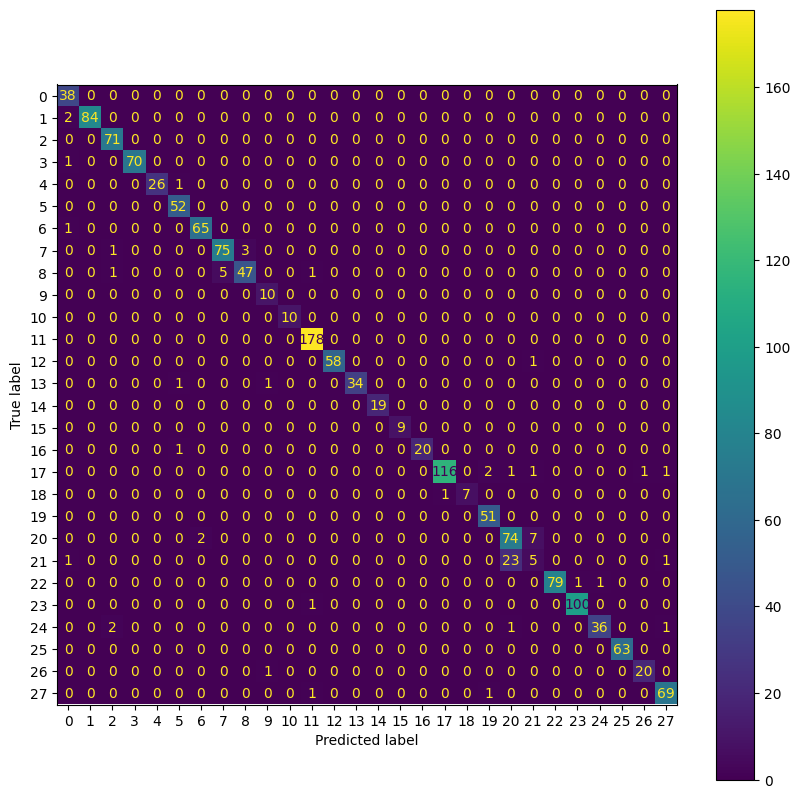

In [8]:
X = ConfusionMatrixDisplay.from_estimator(clf_xgb,
                                      X_test,
                                      y_test)
fig = X.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)  

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [10]:
# Classification report

y_pred = clf_xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        38
           1       1.00      0.98      0.99        86
           2       0.95      1.00      0.97        71
           3       1.00      0.99      0.99        71
           4       1.00      0.96      0.98        27
           5       0.95      1.00      0.97        52
           6       0.97      0.98      0.98        66
           7       0.94      0.95      0.94        79
           8       0.94      0.87      0.90        54
           9       0.83      1.00      0.91        10
          10       1.00      1.00      1.00        10
          11       0.98      1.00      0.99       178
          12       1.00      0.98      0.99        59
          13       1.00      0.94      0.97        36
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00         9
          16       1.00      0.95      0.98        21
          17       0.99    

## Summary results - KNN Imputer

In [11]:
# XGBoost
# make predictions for test data
y_pred = clf_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
F1_score = f1_score(y_test, predictions, average='weighted')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 score: %.2f%%" % (F1_score * 100.0))


Accuracy: 95.44%
Precision: 95.12%
Recall: 95.44%
F1 score: 95.14%


Results from running through Random Forest (ntrees=1000)
- Accuracy: 91.91%
- Precision: 90.79%
- Recall: 91.91%
- F1 score: 91.10%

## IterativeImputer - testing imputation based on running through XGBoost

In [12]:
df_imputed = pd.read_csv("../R/Data/Processed_Data/Itera_filled_data.csv")
df_imputed.drop('Unnamed: 0', axis=1, inplace=True)

X = df_imputed.drop('project_id', axis=1).copy()
X.head()

,1433BETA,1433EPSILON,1433ZETA,4EBP1,4EBP1_pS65,4EBP1_pT37T46,4EBP1_pT70,53BP1,ACC_pS79,ACC1,...,XPF,XRCC1,YAP,YAP_pS127,YB1,YB1_pS102,YTHDF2,YTHDF3,ZAP.70,ZEB1
0,-0.192760,-0.147480,0.274320,-0.166640,0.131930,-0.40350,-0.06129,-0.157290,-0.132990,0.210540,...,-0.253891,-0.05595,-0.12032,0.042403,0.15596,-0.44727,0.184465,0.099395,-1.142633,0.050361
1,0.066082,0.001108,-0.339410,1.317600,0.739550,1.85960,0.59793,-0.313170,0.358690,0.378850,...,-0.268165,-0.28342,-0.12573,0.302280,-0.43544,0.73363,0.220226,0.265941,-1.685293,0.529938
2,0.027610,0.098479,0.795980,0.715850,0.055499,-0.25660,0.19369,-0.746940,0.100000,-0.289240,...,0.059710,-0.61597,0.41376,0.316490,0.18067,0.43394,-0.446973,0.302260,-0.240030,0.236229
3,-0.035859,0.595400,-0.469200,-0.417240,0.353760,2.21680,-0.20124,0.319750,-0.271450,0.103820,...,0.172386,-0.26990,-0.03664,-0.202700,-0.40270,0.63614,-0.096602,0.015607,-0.435979,0.724035
4,0.062445,-0.024017,0.064135,0.082556,-0.477660,-0.33589,-0.33266,-0.085562,-0.048454,-0.033844,...,0.200433,0.14471,-0.26083,-0.369120,-0.37733,-0.13080,-0.510200,-0.669885,0.307318,0.398703


In [13]:
y = df_imputed['project_id'].copy()
y = y.astype(int)
y.head()

0    20
1     5
2     2
3     0
4    11
Name: project_id, dtype: int32

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=180)

In [15]:
clf_xgb = xgb.XGBClassifier(objective='multi:softmax', seed=42, early_stopping_rounds = 10, eta=0.1, eval_metric = 'merror', n_estimators=50, max_depth=6).fit(X_train,
            y_train,
            verbose=True,
            eval_set=[(X_test, y_test)])

[0]	validation_0-merror:0.16570
[1]	validation_0-merror:0.12267
[2]	validation_0-merror:0.10854
[3]	validation_0-merror:0.10083
[4]	validation_0-merror:0.09184
[5]	validation_0-merror:0.08927
[6]	validation_0-merror:0.08349
[7]	validation_0-merror:0.08157
[8]	validation_0-merror:0.07836
[9]	validation_0-merror:0.07836
[10]	validation_0-merror:0.07707
[11]	validation_0-merror:0.07579
[12]	validation_0-merror:0.07450
[13]	validation_0-merror:0.07386
[14]	validation_0-merror:0.07322
[15]	validation_0-merror:0.07450
[16]	validation_0-merror:0.07065
[17]	validation_0-merror:0.06872
[18]	validation_0-merror:0.06551
[19]	validation_0-merror:0.06487
[20]	validation_0-merror:0.06423
[21]	validation_0-merror:0.06358
[22]	validation_0-merror:0.06358
[23]	validation_0-merror:0.06294
[24]	validation_0-merror:0.06294
[25]	validation_0-merror:0.06423
[26]	validation_0-merror:0.06487
[27]	validation_0-merror:0.06487
[28]	validation_0-merror:0.06294
[29]	validation_0-merror:0.06230
[30]	validation_0-me

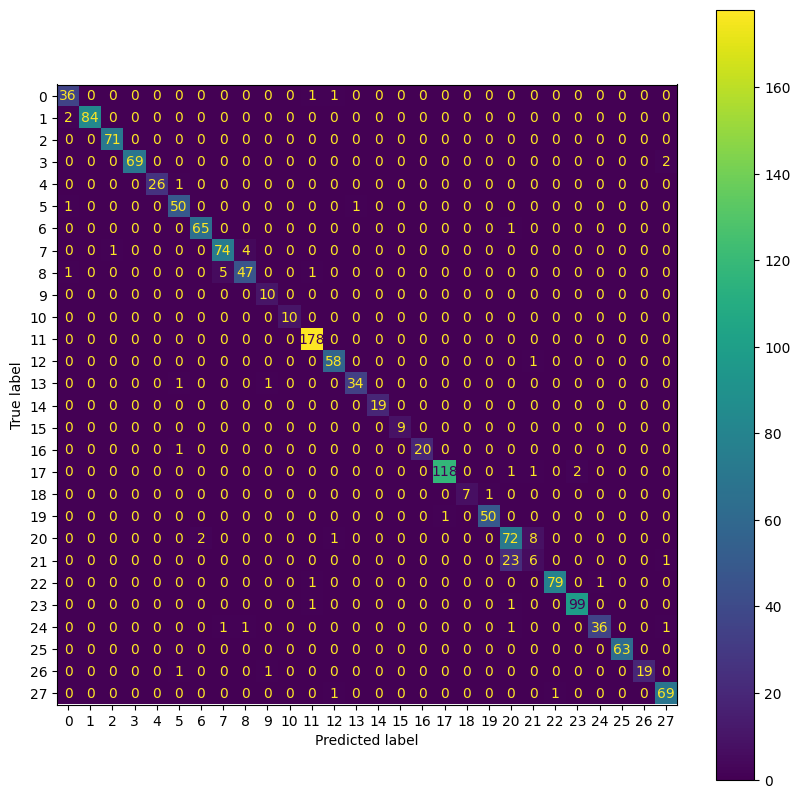

In [16]:
X = ConfusionMatrixDisplay.from_estimator(clf_xgb,
                                      X_test,
                                      y_test)

fig = X.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)

In [17]:
# Classification report

y_pred = clf_xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        38
           1       1.00      0.98      0.99        86
           2       0.99      1.00      0.99        71
           3       1.00      0.97      0.99        71
           4       1.00      0.96      0.98        27
           5       0.93      0.96      0.94        52
           6       0.97      0.98      0.98        66
           7       0.93      0.94      0.93        79
           8       0.90      0.87      0.89        54
           9       0.83      1.00      0.91        10
          10       1.00      1.00      1.00        10
          11       0.98      1.00      0.99       178
          12       0.95      0.98      0.97        59
          13       0.97      0.94      0.96        36
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00         9
          16       1.00      0.95      0.98        21
          17       0.99    

## Summary results - IterativeImputation

In [18]:
# XGBoost results
# make predictions for test data
y_pred = clf_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
F1_score = f1_score(y_test, predictions, average='weighted')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 score: %.2f%%" % (F1_score * 100.0))

Accuracy: 94.93%
Precision: 94.69%
Recall: 94.93%
F1 score: 94.70%


Results from running through Random Forest (ntrees=1000)
- Accuracy: 91.46%
- Precision: 90.41%
- Recall: 91.46%
- F1 score: 90.65%